## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [35]:
# Import libaries 
import os 
import torch 
import tiktoken
import urllib.request
import capra_standard_functions as csf
from matplotlib import pyplot as plt 
%matplotlib inline 

In [36]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
save_dir = "/home/nico/NN_zero_to_hero/Lectures/L7" 
full_path = os.path.join(save_dir, os.path.basename(url))
if not os.path.isfile(full_path):
    _=urllib.request.urlretrieve(url, full_path)

In [37]:
# Read the Shakespeare file 
with open(full_path, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()                                         # Read the file as an entire string 

# txt = csf.read_lblfile("input.txt")                       # Read the file as a list 
watch_num = 250
print(f"In this Shakespeare dataset we have {len(shakespeare_text):,} characters. Let's look at the first {watch_num:d} characters:\n\n{shakespeare_text[:watch_num]}")

In this Shakespeare dataset we have 1,115,394 characters. Let's look at the first 250 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [38]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(shakespeare_text)))         # Create a sorted list of all single characters that occur in the dataset 
vocab_size = len(chars)                             # The vocabulary size is the possible characters in our dataset, i.e. the number of classes 

# Decode to utf-8 in order to be specific about that we also have '\n' and ' ' (i.e. lineskip and a space) as possible characters in the dataset 
print(f"In the Shakespeare dataset we have {vocab_size} unique characters:\n{''.join(chars)}")  # Note the lineskip before printing the characters and that we start with a space of the new line 

In the Shakespeare dataset we have 65 unique characters:

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [39]:
### Create a mapping from characters to integers
# This is our tokenizer --> i.e. our translation from characters into indices, as a NN model cannot take characters directly 

### This is a VERY simply tokenizer --> one of many different tokenizers out there 
# Google uses 'Sentence-Piece' tokenizer => which is a sub-word unit-level tokenizer 
# OpenAI has a library called 'tiktoken' which uses a BPE (Byte-Pair Encoding), which is then used by all GPT models 
stoi = { ch:i for i,ch in enumerate(chars) }                # Dictionary mapping characters to integers 
itos = { i:ch for i,ch in enumerate(chars) }                # Dictionary mapping integers to characters
encode = lambda s: [stoi[c] for c in s]                     # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])            # decoder: take a list of integers, output a string

In [40]:
### Encode and decode our test string using our own encoder and decoder tokenizer 
encode_decode_txt_test_str = "hii there"
ljust_length = 60
print(f"Using our own, simple encoder <-> decoder with a vocabulary size of {vocab_size} and the test string: '{encode_decode_txt_test_str}', we get:")
print(f"Our simple tokenizer-encoder outputs:".ljust(ljust_length) +f"'{encode(encode_decode_txt_test_str)}'")
print(f"Our simple tokenizer-decoding outputs:".ljust(ljust_length) + f"'{decode(encode(encode_decode_txt_test_str))}'")

### Encode and decode our test string using the encoder used for GPT2 by OpenAI 
openai_encoder = tiktoken.get_encoding("gpt2")
print(f"\nThe OpenAI encoder for GPT2 has a vocavulary size of {openai_encoder.n_vocab:,d}")
print(f"Encoding our test string using OpenAI tokenizer gets:".ljust(ljust_length) + f"{openai_encoder.encode(encode_decode_txt_test_str)}")
print(f"Decoding that back using the OpenAI tokenizer gets:".ljust(ljust_length) + f"{openai_encoder.decode(openai_encoder.encode(encode_decode_txt_test_str))}")

### Notice how the vocabulary size of the OpenAI tokenizer is much larger than our simple character level approach 
# This means that they can distinguish between 50k different tokens, whereas we can only distinguish between 65 different characters
# This makes their task way heavier, as that means their final linear layer will have to output a logits vector of length 50k 
# This then means that a model used with such a vocabulary size will have way more parameters than our simple approach model
# However, distinguishing between that many tokens will also allow a model to learn more representative combinations of tokens
# Hence, the OpenAI tokenizer will allow the OpenAI models to become better than our simple character-level based models 
# Notice that in the bottom code block our simple character based tokenizer outputs a list of 9 integers for the two words 'hii there', where as the OpenAI tokenizer only outputs a list of three integers
    # Hence, we can see that there is a tradeoff between having small sequence lengths but large vocabularies (as OpenAI) or longer sequence lengths but with smaller vocabularies (as with our simple approach).

Using our own, simple encoder <-> decoder with a vocabulary size of 65 and the test string: 'hii there', we get:
Our simple tokenizer-encoder outputs:                       '[46, 47, 47, 1, 58, 46, 43, 56, 43]'
Our simple tokenizer-decoding outputs:                      'hii there'

The OpenAI encoder for GPT2 has a vocavulary size of 50,257
Encoding our test string using OpenAI tokenizer gets:       [71, 4178, 612]
Decoding that back using the OpenAI tokenizer gets:         hii there


In [41]:
### Let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(shakespeare_text), dtype=torch.long)                 # Here we encode the entire Shakespeare text dataset and convert these encodings into a torch.tensor 
print(f"Now we have our data of {data.shape} of type {data.dtype}")
print(f"This is the tokens input that our GPT model gets for the first {watch_num} tokens:\n{data[:watch_num]}")   # The first 'watch_num' characters we looked at earier will to the GPT look like this

Now we have our data of torch.Size([1115394]) of type torch.int64
This is the tokens input that our GPT model gets for the first 250 tokens:
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56,

In [42]:
### Let's now split up the data into train and validation sets
n = int(0.9*len(data))          # First 90% will be train, rest validation 
train_data = data[:n]           # Read the first 90% of the dataset     
val_data = data[n:]             # Read the final 10% of the dataset 

In [43]:
### When we are training the Transformer based model, we will never send in the entire dataset
# We will instead feed smaller chunks of data --> the mini-batches 
# In our earlier lectures we have denoted the size of each sequence as our "block_size"
    # This is what's denoted as context_length etc. in other NLP transformer papers 
block_size = 8
print(f"Hence, the string '{decode(train_data[:block_size+1].tolist())}' translates into {train_data[:block_size+1].tolist()}\n")

### Hence, we can create sequences of different lengths
    # We feed in a sequences of as little as 1 token and then all the way up to a sequence of length 'block_size' 
    # This is done in order for the Transformer to learn how to handle sequences of varying sizes 
# When we are going to the inference stage with the Transformer model, the model will then know how to sample and continue on
# from sequences as small as only one token input and all the way up to a sequence of length 'block_size' 
    # If the sequence gets longer than 'block_size', then that's where we start truncating the sequence and remove the first in favour of the last tokens 
x = train_data[:block_size]             # Creating a bunch of sequences from the training data 
y = train_data[1:block_size+1]          # Creating their corresponding targets from the training data, i.e. what character will follow the input sequence 
for t in range(block_size):             # Iterating through all these possible sequence lengths. From 0 all the way to 'block_size' 
    context = x[:t+1]                   # The context length of the sequence will then be the earlier 't' characters 
    target = y[t]                       # The target is then going to be the following character 
    print(f"When input is {context} the target is:".ljust(70) + f"{target}")

Hence, the string 'First Cit' translates into [18, 47, 56, 57, 58, 1, 15, 47, 58]

When input is tensor([18]) the target is:                             47
When input is tensor([18, 47]) the target is:                         56
When input is tensor([18, 47, 56]) the target is:                     57
When input is tensor([18, 47, 56, 57]) the target is:                 58
When input is tensor([18, 47, 56, 57, 58]) the target is:             1
When input is tensor([18, 47, 56, 57, 58,  1]) the target is:         15
When input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is:     47
When input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


In [44]:
torch.manual_seed(1337)         # Set a manual seed for deterministic reproduction 
batch_size = 4                  # how many independent sequences will we process in parallel?
block_size = 8                  # what is the maximum context length for predictions?

# Generate a small batch of data of inputs x and targets y
def get_batch(split):
    data = train_data if split == 'train' else val_data                         # Sample from either the train_data or val_data 
    ix = torch.randint(low=0, high=len(data)-block_size, size=(batch_size,))    # Generate a random integer array of indices of size 'batch_size', sampled from integers between [0, len(data)-block_size]
    x = torch.stack([data[i:i+block_size] for i in ix])                         # Stack the data along the first dimension in a new tensor 
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])                     # Stack the targets, as the sequences taken 1 step further in a new tensor
    return x, y                                                                 # Return both the sequence batch and their corresponding targets 

# Create inputs 
xb, yb = get_batch('train')
print(f"Inputs of shape {xb.shape} => Strings: {[decode(xb[i,:].tolist()) for i in range(xb.shape[0])]}:\nIntegers: {xb}")
print(f"\nTargets of shape {yb.shape} => Strings: {[decode(yb[i,:].tolist()) for i in range(yb.shape[0])]}:\nIntegers: {yb}")
print('-'*100)

### Print the different sequences we are capable of creating from this batch
# We will only print the sequences for the first two rows (half the batch) to save output space ... 
# Hence, this 
for b in range(batch_size//2):      # batch dimension
    for t in range(block_size):     # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"When the input is {context.tolist()} the target is:".ljust(65) + f"{target}")
    print("")

Inputs of shape torch.Size([4, 8]) => Strings: ["Let's he", 'for that', 'nt that ', 'MEO:\nI p']:
Integers: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

Targets of shape torch.Size([4, 8]) => Strings: ["et's hea", 'or that ', 't that h', 'EO:\nI pa']:
Integers: tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----------------------------------------------------------------------------------------------------
When the input is [24] the target is:                            43
When the input is [24, 43] the target is:                        58
When the input is [24, 43, 58] the target is:                    5
When the input is [24, 43, 58, 5] the target is:                 57
When the input is [24, 43, 58, 5, 57] the target is:             1
When 

In [45]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


### This is the most simple model we can build for a language model
# This is a bigram language model, where each token is directly predicted from the previous token
# This is a very simple model, but it is a good starting point to understand the basic concepts of language modeling
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Here we are simply creating an embedding table we can use for embeddings for all our of possible characters 
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        """
        We are simply taking the indices and passing them into the Embedding table 
        Each token we is then only concerned about it-self, as it cannot see any context in this bigram modelling scenario 
        However, we are still in a relatively good position to predict the next token, just from knowing the current token,
        as we know that some tokens are more likely to follow than others
        E.g. if we look at the 'n' token, then we know that a 'g' token is more likely than a 'z' token, hence even though
        the context is very limited, we still have some information to base our predictions on 
        We are then going to use the Negative Log Likelihood (implemented as cross entropy in torch) loss as that is the 
        standard loss function for language modeling 
        
        In this example we have a multi-dimensional input, as we are using (B, T, C) arrays 
        For the cross entropy loss to work, we then have to view the logits and targets to be proper shaped 
        """

        # Idx and targets are both (B, T) tensor of integers
        logits = self.token_embedding_table(idx)                        # (B,T,C)  --> (Batch_size, Time, Channels), where time is the block_size (i.e. context length) of the model 
        loss = None                                                     # As a default, the loss is None in order to allow for logits computations without computing a loss in the generate function

        if targets is not None:                                         # However, if the targets are provided (if we are training the model) ... 
            B, T, C = logits.shape                                      # ... extract the dimensions of the logits (which is the embedded inputs) i.e. (4, 8, 65)
            logits = logits.view(B*T, C)                                # ... view the logits as a 2D array of (B*T, C), i.e. (32, 65), i.e. the two "batch" dimensions multiplied and the embedding dim 
            targets = targets.view(B*T)                                 # ... view the targets as a 1D array of (B*T) i.e. (65)
            loss = F.cross_entropy(logits, targets)                     # ... compute the cross entropy loss, i.e. this will measure the "quality" of the logits compared to the targets 
        
        return logits, loss                                             # Return the logits and the computed loss 


    def generate(self, idx, max_new_tokens):
        """
        Sample from the model using a generation function
        idx is (B, T) array of indices in the current context
            The idx is the current context of some characters in a batch, hence the size (B, T)
        The job for this generate function is to generate new samples, i.e. expanding the context to (B, T+1), then (B, T+2) ... (B, T+max_new_tokens) 
            I.e. we are going to generate new characters from the model in the time dimension for the batch 
        However, notice here that this is a very simple bigram model, where we feed in the entire context history, 
        even though we for the bigram model will only use the last character in the context
        However, we want to be able to keep this function somewhat fixed, when the model is extended, hence we just keep in feeding the entire list of context (=past characters) 
        """
        for _ in range(max_new_tokens):                                 # Iterating over the maximum number of tokens allowed 
            logits, loss = self(idx)                                    # Make a prediction with the model 
            logits = logits[:, -1, :]                                   # Focus only on the last time step of the logits --> the logits becomes (B, C), this is because we only focus on the final predicted character 
            probs = F.softmax(logits, dim=-1)                           # apply softmax to get probabilities --> probs are of shape (B, C)
            idx_next = torch.multinomial(probs, num_samples=1)          # sample from the distribution --> idx_next is of shape (B, 1), because we only have a single new character prediction we predict 
            idx = torch.cat((idx, idx_next), dim=1)                     # append sampled index to the running sequence --> idx is of shape (B, T+1), as we appended the new character to the sequence 
        return idx

In [46]:
### Initiate the simple bigram language model and try a simple forward pass 
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

### Compute the expected initial loss 
# We have a vocabulary of 65. 
# Initially we expect each of the characters to be equally likely, as the model is simply randomly initialized 
# Hence, we can compute the negative log likelihood loss of a uniform distribution 
    # The NLL loss: log(-1 * p)
    # The probability for each of the characters are assumed to be 1/vocab_size 
initial_expected_probability = 1/65
expected_initial_loss = -torch.log(torch.as_tensor(initial_expected_probability))
actual_prob_for_example_character = torch.exp(-loss)
print(f"We can see that we are expecting an initial loss of about {expected_initial_loss:.4f} from an estimated initial probability of {initial_expected_probability:.4f}")
print(f"Now we have logits of shape {tuple(logits.shape)} and the loss of {loss.item():.4f}") 
print(f"This means that the average probability for the predicted first character is {actual_prob_for_example_character:.5f}")

We can see that we are expecting an initial loss of about 4.1744 from an estimated initial probability of 0.0154
Now we have logits of shape (32, 65) and the loss of 4.8786
This means that the average probability for the predicted first character is 0.00761


In [47]:
### Sample from the model 
initial_idx = torch.zeros((1,1), dtype=torch.long)                                  # As decode([0])=\n, this seems like a reasonably, fair starting token 
max_tokens = 100                                                                    # The number of new tokens/characters we want to generate from the model 
print(decode(m.generate(idx = initial_idx, max_new_tokens=max_tokens)[0].tolist())) # Print the 100 generated characters from the untrained model 


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [48]:
### Create a PyTorch optimizer
# The Adam optimizer is way more advanced than SGD, as we have been using in earlier lectures
# This is because ADAM uses momentum for the first and second order statistics of the gradients
# This will allow for "varying learning rates" for each of the parameters, as the momentum will take 
# care of "scaling" the learning rate appropriately 
### A typical good starting learning rate would be around 1e-4 or perhaps 1e-3, but for such a small
# network as what we have for the bigram model here, 1e-3 is probably a bit too low, and we could 
# probably afford starting with a higher learning rate 
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)              

In [49]:
batch_size = 32                             # Initial batch size 
num_iterations = 10000                      # The number of iterations to train for
loss_list = list()                          # Create a list to store the loss for each iteration 

In [50]:
### Define a small training loop, where we train the bigram model 
for steps in range(num_iterations): 

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step() 
    loss_list.append(loss.item())
print(f"After {len(loss_list)} iterations, loss = {csf.moving_average(loss_list,150)[-1]:.5f}")

After 10000 iterations, loss = 2.47019


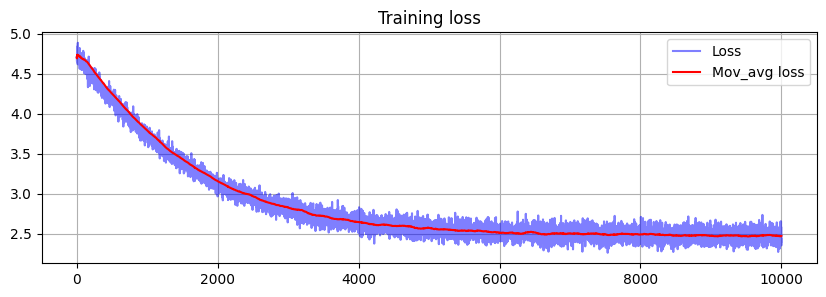

In [51]:
fig = plt.figure(figsize=(10,3))
plt.plot(torch.linspace(start=1,end=len(loss_list), steps=len(loss_list)), loss_list, color="blue", alpha=0.5, label="Loss")
plt.plot(torch.linspace(start=1,end=len(loss_list), steps=len(loss_list)), csf.moving_average(inp_array=loss_list, n=150), color="red", label="Mov_avg loss")
plt.grid(True)
plt.legend()
plt.title("Training loss")
plt.draw()

In [52]:
### Sample from the now trained bigram model 
initial_idx = torch.zeros((1,1), dtype=torch.long)                                  # As decode([0])=\n, this seems like a reasonably, fair starting token 
max_tokens = 200                                                                    # The number of new tokens/characters we want to generate from the model 
print(decode(m.generate(idx = initial_idx, max_new_tokens=max_tokens)[0].tolist())) # Print the 100 generated characters from the untrained model 


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo 


## The mathematical trick in self-attention

##### v1) Running average of features - for loop

In [53]:
### consider the following toy example:

torch.manual_seed(1337)

"""
they are currently not talking to each other, but we want to couple them in a very specific way
e.g. the tokens in e.g. position 5 should not be talking to tokens in position 6 or 7, as they are future tokens
but tokens in position 5 should only be talking to earlier tokens, in position 1,2,3,4 ... 
    Information is only allowed to flow from earlier context to the current time-steps 
So, what is the easiest way for tokens to communicate? 
    - The simplest weight to communicate with the previous tokens is simply to average the earlier steps.
        - i.e. for the 5th token, the easiest way to communicate with the previous context would be to take the mean
        of the four earlier embedded tokens, hence that could be some kind of feature vector to use 
        - However, the average feature vector is a noisy context -> we can't tell which are the important ones,
        and we lost a lot of information by averaging all the earlier tokens 
    - For every single batch element (i.e. for every t'th element) we want to compute the feature vectors for earlier tokens
        - This is what we are calling the bag-of-words features for the current token
"""

B,T,C = 4,8,2                       # batch, time, channels => 
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [54]:
# We want x[b,t] = mean_{i<=t} x[b,i]
"""
- Here we will compute the bag of words
    - We run through each sample in the batch ...
        - For each sample:
            - we extract the previous tokens => into a tensor of shape (t, C), where t is the point
                        in time we have reached and C is the number of channels (embedding dimension) 
            - we take the mean of those previous tokens along the time dimension and
                        add that to our bag-of-words feature array => this is an array of shape (C)
"""
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] 
        xbow[b,t] = torch.mean(xprev, 0)

In [55]:
### Print the x array and the x_bow tensor array in order to inspect them and visualize what we just did
print(f"The first sample of x:\n{x[0]}\n\nThe first sample of xbow:\n{xbow[0]}")

"""
Notice that the first rows of the two tensors are equal [0.1808, -0.0700].
    Because at the first row (i.e. first time step) we have only one context token to compute the mean over 
From the second row and on the two tensors differ
    As now the xbow becomes a rolling mean of the previous inputs of x 
""";

The first sample of x:
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

The first sample of xbow:
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


##### v2) Running average of features - matrix multiplication with summing normalization

In [56]:
### toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
# This is a toy example to use to get used to what self-attention is and how it works 
"""
Notice here that we create the three tensor matrices a, b, c
    We run through three examples:
        1) Triangular = False, normalization = False 
        2) Triangular = True, normalization = False
        3) Triangular = True, normalization = True 
    In each example we create the a (which may or may not be edited) and b matrices.
    Then we form c by taking the dot product between a and b.
        The values of c is then what's interesting to us here 
    *** Remember the dot product m*n is computed by multiplying each element in the columns of the first matrix by each of the elements in the rows of the second matrix *** 
Example 1)
    - If a is all ones => the resulting c matrix will be equal in each row:
        - torch.equal(c[0,:], c[1,:]) and torch.equal(c[0,:], c[2,:]) 
        >>> True 
Example 2)
    - If a is a lower triangular matrix of all ones => the resulting c matrix will be the cumulative sum of the b matrix 
        - i.e. the first row of c will be identical to the first row of b, as the cumulative sum of a single row is just that row
        - the second row of c is then equal to the first and second row of b summed together 
        - the third row of c is then equal to all the rows of example 1), as it is the sum of all three rows of b
Example 3)
    - If a is a lower triangular matrix of all ones, and then it gets normalized to make the sum of each row '1', the resulting c matrix will be the moving average of b
        - i.e. the first row of c will be identical to the first row of b, as the moving average of a single row is just that row
        - the second row of c is then equal to the average of the first and second row of b 
        - the third row of c is then equal to the average of the first three rows of b 
"""


triangular = True 
normalization = True 


### Running our experiments 
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) if triangular else torch.ones(3, 3) 
a = a / torch.sum(a, 1, keepdim=True) if normalization else a 
b = torch.randint(0,10,(3,2)).float() 
c = a @ b 
print(f"a:\n{a}\n{'-'*23}\nb:\n{b}\n{'-'*23}\nc:\n{c}") 

a:
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
-----------------------
b:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
-----------------------
c:
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [57]:
### version 2: using matrix multiply for a weighted aggregation
# Hence, now we are doing weighted sums, as with the for loop before,
# we are just doing it using matrix multiplication, which is way more efficient 
wei = torch.tril(torch.ones(T, T))              # torch.tril will give us the lower triangular part of the torch.ones() tensor (earlier denoted a)
wei = wei / wei.sum(1, keepdim=True)            # Normalize the weight matrix (earlier denoted b)
xbow2 = wei @ x                                 # (B, T, T) @ (B, T, C) ----> (B, T, C), because, broadcasting happens along the batch dimension (earlier denoted c)

print(f"The xbow and xbow2 are {'' if torch.allclose(xbow, xbow2, rtol=1e-15, atol=1e-6) else 'NOT '}equal")

The xbow and xbow2 are equal


##### v3) Running average of features - matrix multiplication with softmax normalization

In [58]:
### version 3: use Softmax
# Now we are going to use the weighted sum of features as in version 2
# However, now we are going to use a softmax along the rows in order to assure that 
# the sum of each row will be 1
# Hence, using the softmax is equal to what was done before in version 2
# as the weight matrix used here for example 3 will be equal to what was done in version 2

# The weight matrix here will tell us how much each of the tokens from the past will contribute to the value of the new prediction
# Setting some values to -inf before the softmax will make sure that the current tokens will not be able to communicate with future tokens
# This trick with taking some average of the earlier inputs will then allow for tokens to interact with earlier inputs
# Later (the self-attention trick) will allow us to make weighted averages of the earlier tokens
    # Hence, with a weigted average, we can interprete it as the tokens will tell which earlier tokens are important, and which are not
    # Thus, the important earlier tokens will be attended to (i.e. getting a high value) where as the non-important tokens will get a low value 
# Remember, in a Transformer, we will have different heads to compute attention, similar to having different kernels in each layer in a CNN
    # These different heads will attend to different parts of the input, i.e. find different input parts interesting 

tril = torch.tril(torch.ones(T, T))                                                                                                         # Create a lower triangular matrix of shape (T, T)
wei = torch.zeros((T,T))                                                                                                                    # Initiate the weight matrix as all zeros of the same shape 
wei = wei.masked_fill(tril == 0, float('-inf'))                                                                                             # Read all the indices where the lower triangular matrix is 0 and fill those with -inf values in the weights matrix
wei = F.softmax(wei, dim=-1)                                                                                                                # Compute a softmax for each row. The filled -inf values turns to 0 in the softmax (as exp(-inf)=0). Hence this is equal to what was done before in example 2.
xbow3 = wei @ x                                                                                                                             # Compute the normalized bag of features for the x input using the softmax-normalized weight matrix 

print(f"The xbow and xbow3 are {'' if torch.allclose(xbow, xbow3, rtol=1e-15, atol=1e-6) else 'NOT '}equal")

The xbow and xbow3 are equal


##### v4) BoW features - matrix multiplication turns to self-attention

In [59]:
### version 4: self-attention!
# This is self-attention for a single attention-head!
"""
Every single token will emit two vectors => a query (what am I looking for) and a key (what do I contain) 
    We will then find similarities by taking the dot product between the query and the key 
Hence, to begin with, we have to create the key and the value
    - This is done by multiplying the input with a separate layer, one for the key, one for the query 
    - Our input is of shape (4, 8, 32). The layers are of shape (16, 32). Hence --> out = x @ w.T 
Now, the communication starts --> now we can start to find affinities (=likings) between keys and queries
    - We will take the dot product between the keys and the queries 
        However, notice the shapes of the keys (4,8,16) and the queries (4,8,16)
        As the first one is the batch dimension, which we don't want to multiply over, we need to transpose the keys ...
        Hence, we transpose the keys from (4,8,16) into (4,16,8)
        Then we can compute the dot product between the queries and the keys 
    - Hence, we can interprete this as the weight matrix and then do as before out = wei @ x
        This will create an output of both positive and negative values 
            This we can interprete as the affinities between all the tokens (nodes)
            However, we don't like negative affinities, hence we normalize and use the softmax to get numbers between 0 and 1, that sum to 1 
    - However, we don't want any node/token to be able to communicate with future tokens (tokens with higher timesteps)
        Hence, if we use the masking future information/tokens are washed out
Now we have the attention weights for the inputs
    - Though, we are not quite done, as we still need the final layer of the attention head --> the values 
        The values (v tensor) are what is returned to the inputs, if the queries and keys are matched 
Attention is a communication mechanism - we have a number of connections between each of the nodes corresponding to the tokens 
    - In this scenario we have a block size of 8, which means we always have 8 nodes
        The first node will only point to itself
        The second node points to itself and the first node 
        The third node points to itself, the second and the first node 
        ....
        The eighth node points to all the other nodes in our context 
There is NO communication across the batch dimension
    - No two samples in the batch are talking to each other, there are only communication across the tokens in the input sequence in each batch 
At the moment, as we have implemented it now, the tokens cannot talk to future tokens 
    - In a Transformer decoder block, where we might want to perform text generation by always predicting the next token, we will have to mask future tokens in our training sequence 
    - However, it doesn't necessarily has to be like that.
        For encoder based applications we will remove the masking ---> remove: wei = wei.masked_fill(tril == 0, float('-inf'))
            If we are doing sentiment analysis, we may want to make all tokens in the sentence able to talk to each other across the time dimension
            This we would do in order for the model to come up with a single sentiment score for the entire sequence 
    - However, we can remove the masking, and then everything will just run and work fine
        The attention mechanishm itself doens't care whether or not it has been masked ... 
Notice here that we have no notion of positional space ---> hence, by default the tokens/nodes have no notion of where they are located in space
    This is different from e.g. convolution, where the very definition of a filter sliding across an image will incorporate the positional knowledge
    - Hence, in order to gain positional knowledge we have to make positional embeddings as well
        We will usually simply make these positional embeddings learnable as well, like the token embeddings
            token_embedding_table = nn.Embedding(vocab_size, n_embd)
            position_embedding_table = nn.Embedding(block_size, n_embd)
            x = token_embedding_table + position_embedding_table
        Hence, the embeddings for the tokens and the positions will start of by being random, but will be learnable through training 
Multiple kinds of attention:
    - Self-Attention:
        Self attention simply means that the keys, queries and values arrive from the same source
        Hence, the inputs are attending to itself 
    - Cross-Attention:
        In encoder-decoder transformers we can have a case where the queries are from the inputs, where the keys and values are from a separate source
        Cross-attention happens when we have multiple sources where we want to incorporate some information from into our system
            These other sources might be from other encoder blocks, where their outputs arrive into a decoder input 
Scaled dot product attention:
    - If we look at the Attention Is All You Need paper we can see that the attention equation is scaled by the sqrt(dk)
        This is for a similar reason as why weight initialization for neural networks are important
    - If we don't scale the attention weights we can get a super high variance in our "wei" matrix 
        As the keys and queries can be unit variance, the variance of their dot product can be pretty high
    - The problem is that if the wei matrix takes on too high numbers, the softmax will converge to a onehot encoding 
"""



use_triangular_matrix = True                    # If True we use a decoder (masked future), if False we use an encoder 
use_softmax = True                              # If True, normalize the weight matrix along the rows 
use_value_layer = True                          # If true, use a Value layer to compute the outputs 


torch.manual_seed(1337)
B,T,C = 4,8,32                                  # batch, time, channels
x = torch.randn(B,T,C)                          # Create an input of random numbers 

# let's see a single Head perform self-attention
head_size = 16                                  # The number of elements in the key, query, value tokens 
key = nn.Linear(C, head_size, bias=False)       # key: "what do the token contain" 
query = nn.Linear(C, head_size, bias=False)     # query: "what do the token want"
value = nn.Linear(C, head_size, bias=False)     # value: "what do the token receive"
k = key(x)                                      # (B, T, head_size)   --->   nn.Linear()(x) ==> x @ w --->  multiplying the input of...
q = query(x)                                    # (B, T, head_size)   --->   ... shape (4,8,32) with the linear layer of shape (16, 30) ...
v = value(x)                                    # (B, T, head_size)   --->   ... which gets transposed to (32, 16), yields a (4,8,16) 
k_transposed = k.transpose(-2, -1)              # Transpose from shape (4,8,16) --> (4,16,8).                                                               Remember that torch.transpose(source_dim, target_dim), hence we take the -2dim and swap with the -1 dim 
wei =  q @ k_transposed                         # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

### Now comes the trick, weighted averages of the inputs 
if use_triangular_matrix: 
    wei = wei.masked_fill(torch.tril(torch.ones(T, T))  == 0, float('-inf'))
if use_softmax:
    wei = F.softmax(wei, dim=-1)

### Compute the output from either the orig input or the values 
out = wei @ (v if use_value_layer else x)

print(f"This is the weight matrix of shape {tuple(wei.shape)} with the first parameters\n{wei[0]}")
print(f"\nThis is the output of shape {tuple(out.shape)} of the attention head with the selected parameters:\n{out[0,]}")

This is the weight matrix of shape (4, 8, 8) with the first parameters
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

This is the output of shape (4, 8, 16) of the attention head with the selected parameters:
tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        [ 0.6764, -0.5477, -0.2478,  0.3143, -0

##### Scaling the weight matrix with sqrt(dk) 

In [60]:
### The reason why we need to scale the weights matrix before the softmax 
torch.manual_seed(4)
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1)
wei_scaled = wei * head_size**-0.5
print(f"Without scaling the variance of the weights matrix is {wei.var():.3f}.")
print(f"With scaling the variance of the weights matrix is {wei_scaled.var():.3f}.")

Without scaling the variance of the weights matrix is 17.801.
With scaling the variance of the weights matrix is 1.113.


##### Scaled dot product attention

In [28]:
### The softmax will converge towards a one hot encoding 
# Especially at initialization we don't want the softmax outputs to be too peaky/sharp, as that would mean 
# that we would have only one node contributing to the attention mechanism, as a onehot encoded output
# from the softmax would be equal to plugging out a single node of the weight matrix 

test_tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])
test_scale = 8 
print(f"This is the output of the torch.softmax(test_tensor):".ljust(57) + f"{torch.softmax(test_tensor, dim=-1)}")
print(f"This is the output of the torch.softmax(test_tensor)*{test_scale}:".ljust(57) + f"{torch.softmax(test_tensor*test_scale, dim=-1)}")

This is the output of the torch.softmax(test_tensor):    tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
This is the output of the torch.softmax(test_tensor)*8:  tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. 

## Implementing the Language model

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(shakespeare_text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(shakespeare_text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))            # Not a weight parameter, hence in PyTorch we need to "register_buffer" 

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
